# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on several
datasets. As part of the practical you should read briefly the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier (NBC)

You should implement a Naïve Bayes Classifier from scartch using NumPy. To keep your code tidy,
we recommend implementing it as a class. 
The classifier should be able to handle binary and continuous features. 
To earn the bonus points, the classifier should be able to handle categorical features as well. 
Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'])

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y \mid \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The **fit** function is to estimate all the parameters ($\theta$ and $\pi$) of the NBC, i.e., train the classifier. The **predict** function computes the probabilities that the new input belongs to all classes and
then returns the class that has the largest probability, i.e., makes a prediction.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [4]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np

### Class-conditional distributions

Before implementing NBC, we first implement the class-conditional distributions $p(\mathbf{x} \mid y, \theta)$. Your implementation should have two functions: **estimate** and **get_log_probability**. 

- The **estimate** function takes data as input and models the data using some distribution $p(x \mid \theta)$, where $\theta$ is the parameters of this distribution. The function estimates the parameters $\theta$ using maximum likelihood estimators (MLE). 
For example, in the case of continuous features, we use the Gaussian distribution to model the data. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data. 

- The **get_log_probability** function takes as input a new data point $x_{new}$ and returns the log of $p(x_{new} \mid \theta)$. For the Gaussian distribution, the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma^2)$. 

For different types of features, you need to use different distributions.
You can import statistic libraries (e.g., `scipy.stats`) for the implementation of the distributions. 

- For **continuous features**: Use Gaussian distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
- For **binary features**: Use Bernoulli distribution 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html
- For **categorical features**: Use Multinoulli distribution (The multinoulli distribution is a special case of the multinomial distribution, where the number of trials is 1)
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html

Example: https://stackoverflow.com/questions/12412895/how-to-calculate-probability-in-a-normal-distribution-given-mean-standard-devi


**Implementation Issues:**
- The probabilities can be very small. To avoid underflow issues, you should compute the log of the probabilities. Read more: (Mur) Chapter 3.5.3 / Lecture Notes
- The variance for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6. This is to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. 
For this practical, please set the small value to 1e-6.
- Laplace/Additive smoothing: You want to ensure that the estimates for the parameter for the Bernoulli and Multinoulli random variables is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).
For this practical, please set alpha to 1.
- For simplicity, you can assume the data values for binary features are integers from {0,1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.


In [5]:
from scipy.stats import norm
from scipy.stats import bernoulli
from scipy.stats import multinomial

In [6]:
ALPHA = 1.0 # for additive smoothing
# Distribution for continuous features
class ContFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        self.loc, self.scale = norm.fit(X)
        if self.scale == 0:
            self.scale = 1e-6
        return self.loc, self.scale
        
    def get_log_probability(self, X_new):
        # TODO: return the log of the density values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        log_pdf = norm.logpdf(X_new,loc=self.loc,scale= self.scale)
        return log_pdf

# Distribution for binary features
class BinFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Bernoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        # X is a vector with binary values
        # Laplace/Additive smoothing
        self.p = (sum(X)+ALPHA)/(len(X)+ALPHA*2)

    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        log_pmf = bernoulli.logpmf(X_new,self.p)
        return log_pmf

# Distribution for categorical features
class CatFeatureParam:
    
    # we need to know the number of categories for the categorical feature
    def __init__(self, num_of_categories):
        self._num_of_categories = num_of_categories
    
    def estimate(self, X):
        # TODO: Estimate the parameters for the Multinoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        self.plist = []
        self.X_N = list(X)
        # categorical feature with M categories are integers from {0, ..., M-1}.
        for i in range(0,self._num_of_categories):
            self.plist.append((self.X_N.count(i)+ALPHA)/(len(X)+ALPHA*int(self._num_of_categories)))
        return self.plist
    
    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        self.mylist = []
        
        for i in range(0,len(X_new)):
            x_v = np.zeros(self._num_of_categories)
            x_v[X_new[i]] = 1
            self.mylist.append(x_v)
        self.reslist = np.array(self.mylist).reshape(len(X_new),self._num_of_categories)
        log_pmf = multinomial.logpmf(self.reslist,n=1,p=self.plist)
        return log_pmf
            
        

**Tests:**
    
We will use the code below to test the correctness of your code.

In [7]:
# continuous features

X = np.array([2.70508547,2.10499698,1.76019132,3.42016431,3.47037973,3.67435061,1.84749286,4.3388506,2.27818252,4.65165335])

param = ContFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3]))
print(probs)

[-5.64670664 -3.02757918 -1.44567455 -0.90099277]


In [8]:
# binary features

X = np.array([0,0,1,1,0,1,0,1,1,1])

param = BinFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1]))
print(probs)

[-0.87546874 -0.5389965 ]


In [9]:
# categorical features (bonus task)

X = np.array([0,6,5,4,0,6,6,4,1,1,2,3,8,8,1,6,4,9,0,2,2,3,8,0,2])

param = CatFeatureParam(num_of_categories=10)
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3,4,5,6,7,8,9]))
print(probs)

[-1.94591015 -2.1690537  -1.94591015 -2.45673577 -2.1690537  -2.86220088
 -1.94591015 -3.55534806 -2.1690537  -2.86220088]


### Implement NBC

We are now ready to implement NBC. We follow the structure of models in scikit-learn. We implement NBC as a class with functions **init**, **fit** and **predict**.
The **init** function takes as input the types of features and initialise the classifier. The **fit** function takes the training data as input and estimates the parameters. The **predict** function predicts the label for the input data. 

**Implementation Issues:**
- You should use matrix operations rather than loops. In general, loops over classes or features are OK, but loops over the rows of data are not a good idea.
- The probabilities can be very small. To avoid underflow issues, you should do the calculations in log space. Read more: (Mur) Chapter 3.5.3 / Lecture Note
- For simplicity, you can assume the data values for binary features are integers from {0, 1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.

In [10]:
# Your task is to implement the three functions of NBC. 

class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['b', 'r', 'c']
    def __init__(self, feature_types=[]):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        self.feature_types = feature_types

        
    # The function uses the input data to estimate all the parameters of the NBC
    def fit(self, X, y):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        self.ycat, self.ycount = np.unique(y, return_counts = True)
        self.xcat = len(np.unique(X))
        self.p = []
        self.theta = []
        for i in range(0,len(self.ycat)):
            self.p.append(self.ycount[i] / len(y))
            for j in range(0,len(self.feature_types)):
                if self.feature_types[j] == 'b':
                    self.theta.append(BinFeatureParam())
                elif self.feature_types[j] == 'r':  
                    self.theta.append(ContFeatureParam())
                else:
                    self.theta.append(CatFeatureParam(num_of_categories = self.xcat))
                X_N = X[y == self.ycat[i],j]
                self.theta[i*len(self.feature_types)+j].estimate(X_N)
                
                
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        p_m = np.zeros((X.shape[0],len(self.ycat)))
        for i in range(len(self.ycat)):
            p_m[:,i]=np.log(self.p[i])
            for j in range(len(self.feature_types)):
                x_n = X[:,j]
                p_m[:,i]+=self.theta[i*len(self.feature_types)+j].get_log_probability(x_n)
        predicted_c = np.argmax(p_m,axis = 1)
        return predicted_c
                

**Tests**

We will use the code below to check your code.

In [11]:
# All features of the iris dataset are continuous.

from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 90%
print(yhat)

Accuracy: 0.9333333333333333
[2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [12]:
# All features of this dataset are binary
import pandas as pd
data = pd.read_csv('binary_test.csv', header=None)
data = data.to_numpy()

X = data[:,1:]
y = data[:,0]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['b'] * 16)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 85%
print(yhat)

Accuracy: 0.8723404255319149
[1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 0
 0 0 1 0 0 0 0 1 1 0]


In [13]:
# All features of this dataset are categorical (bonus task)
import pandas as pd
data = pd.read_csv('categorical_test.csv', header=None)
data = data.to_numpy()

X = data[:,:-1]
y = data[:,-1]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['c'] * 9)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 65%
print(yhat) 

Accuracy: 0.6896551724137931
[0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Logistic Regression

For logistic regression (LR), you should use the implementation in scikit-learn. Add the following
line to import the LR model.

In [14]:
from sklearn.linear_model import LogisticRegression

Check the scikit-learn documentation for the Logistic Regression model:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

The experiment is to compare the classification error of the NBC and LR trained on increasingly larger training datasets. 
Since the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a function of the size of the training data. 
We have written for you the function for making the plots for the experiments. 

In [34]:
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10):
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    
    
    tst_errs_nbc = np.zeros((num_splits))
    tst_errs_lr = np.zeros((num_splits))
    N, D = X.shape

    for i in range(0,num_splits):
        list_nbc = []
        list_lr = []
        for j in range(0,num_runs):      
            Ntrain = int(N*(i+1)/num_splits)
            Ntest = int(0.2 * N) 
            
            shuffler = np.random.permutation(N)
            X_train = X[shuffler[:Ntrain]]
            y_train = y[shuffler[:Ntrain]]  
            X_test = X[shuffler[Ntest:]]
            y_test = y[shuffler[Ntest:]]
            
            nbc.fit(X_train, y_train)
            nbc_ypredicted = nbc.predict(X_test)
            nbc_test_err = np.mean(nbc_ypredicted != y_test)
            
            lr.fit(X_train, y_train)
            lr_ypredicted = lr.predict(X_test)  
            lr_test_err = np.mean(lr_ypredicted != y_test)
            
            list_nbc.append(nbc_test_err)
            list_lr.append(lr_test_err)
            
        tst_errs_nbc[i] = np.mean(list_nbc)
        tst_errs_lr[i] = np.mean(list_lr)
            
        
            
    return tst_errs_nbc, tst_errs_lr


In [38]:
def makePlot(tst_errs_nbc, tst_errs_lr, title=None, num_splits=10):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * (100/num_splits) for i in range(num_splits)]
    plt.plot(xaxis_scale, tst_errs_nbc, label='Naive Bayes')
    plt.plot(xaxis_scale, tst_errs_lr, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers, e.g., handle missing values, handle text/categorical data, etc.
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

# Report 1 : Iris Dataset
1. The data set is relatively complete, and no other preprocessing is required, only the training set needs to be divided
2. At first, the naive bayes' error is lower than LR, but with the dataset becoming larger, the LR is better than the naive bayes.
3. Thus, we could know that with the number of data becoming larger, the discriminative method is better than the generative method.

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/liminghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

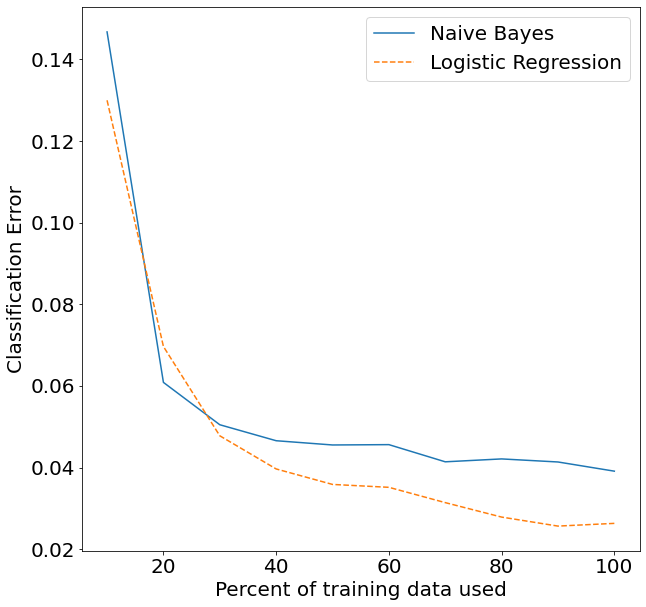

In [39]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
from sklearn.datasets import load_iris
iris = load_iris()

X, y = iris['data'], iris['target']

nbc = NBC(feature_types=['r', 'r', 'r', 'r'])
lr = LogisticRegression(random_state=0)

nbc_perf, lr_perf = compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10)
makePlot(nbc_perf, lr_perf, title=None, num_splits=10)
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records

The logistic regression line meets the naive bayes line early in the plot. To see it clearer, you should use only 100 data points from the dataset for this experiment.

# Report 2: Voting Dataset
1. This dataset is not comleted. We first delete some incopleted data. Then we change the str value to number 1 and 0 because of the binary labels. And then we shuffler the data because of the small number dataset.
2. We could see that the naive bayes' error is always larger than the LR's.
3. Thus, we could say that most time the discriminative model is more efficient than the generative model.
“One should solve the [classification] problem directly and never solve a more general problem as anintermediate step [such as modelling 𝑝(𝑥, 𝑦|𝜃, 𝜋)]” which is true in this dataset.

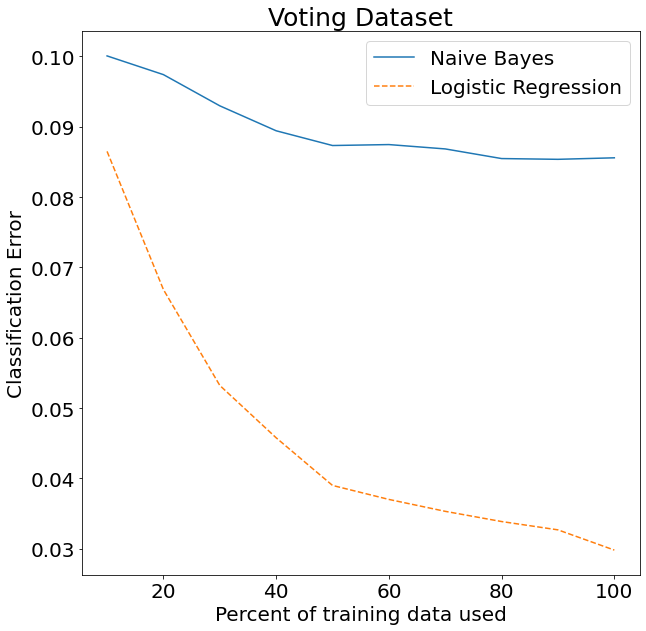

In [43]:
# load the dataset
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################

voting = pd.read_csv('voting.csv')

voting_data = voting.dropna()
voting_data = voting_data.replace({"y":1, "n":0, "democrat":1, "republican":0})
voting_data = voting_data.to_numpy()

shuffler = np.random.permutation(voting_data.shape[0])

X = voting_data[shuffler[:100], 1:]
y = voting_data[shuffler[:100],0]

nbc = NBC(feature_types=['b'] * 16)
lr = LogisticRegression(random_state=0)

nbc_perf, lr_perf = compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10)
makePlot(nbc_perf, lr_perf, title=None, num_splits=10)